In [265]:
pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [266]:
!pip install --upgrade spacy
!python -m spacy download ru_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-10-30 17:41:59.990860: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [267]:
import sqlite3
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pymorphy2
import spacy
import seaborn as sns

# Pre-working with dataframe


In [268]:
df = pd.read_csv('csv.csv', sep=',', encoding='utf-8')
df = df[['id', 'firstAuthor', 'title', 'subtitle', 'yearNormalized', 'size', 'numOfSpeakers', 'numOfSpeakersFemale', 'numOfSpeakersMale', 'numOfSpeakersUnknown', 'wordCountText', 'wordCountSp', 'wordCountStage', 'numOfP', 'numOfL']]
author_id_df = pd.DataFrame({'firstAuthor':df["firstAuthor"].unique()})
author_id_df["authorID"] = author_id_df["firstAuthor"].str[:3] + author_id_df.index.astype(str)
#print(author_id_df)
df = pd.merge(df, author_id_df, on='firstAuthor')
print(df.head())

          id firstAuthor      title  \
0  rus000167  Афиногенов   Машенька   
1  rus000194     Андреев  К звёздам   
2  rus000137     Андреев      Мысль   
3  rus000138     Андреев    Не убий   
4  rus000211   Арцыбашев   Ревность   

                                            subtitle  yearNormalized  size  \
0                      Пьеса в 3-х актах 7-ми сценах            1941    12   
1                                                NaN            1906    13   
2  Современная трагедия в трех действиях и шести ...            1914    15   
3                                                NaN            1913    23   
4                           Драма въ 5-ти дѣйствіяхъ            1913    11   

   numOfSpeakers  numOfSpeakersFemale  numOfSpeakersMale  \
0             12                    6                  5   
1             13                    4                  9   
2             15                    6                  9   
3             23                    9                 14

## Number of dramas per authors


In [269]:
dramas_per_author = df["authorID"].value_counts()
dramas_per_author_df = pd.DataFrame(dramas_per_author)
dramas_per_author_df = dramas_per_author_df.reset_index()
dramas_per_author_df.columns = ['authorID', 'NOfDramas']

print(dramas_per_author_df)

   authorID  NOfDramas
0     Ост37         38
1      Чех7         14
2     Сум51         14
3      Бул6         10
4     Тур54          9
5     Кры24          8
6     Кня21          8
7     Гог12          8
8     Пуш44          7
9     Пру43          6
10    Тол52          5
11    Шах47          4
12    Гум15          4
13    Хме20          4
14    Фон10          4
15    Нек35          4
16    Пис40          3
17    Мая32          3
18    Лер27          3
19    Хер18          3
20    Сух50          3
21     Анд1          3
22    Гор13          3
23     Ека9          3
24     Бло5          3
25    Лом29          2
26    Мам31          2
27    Май30          2
28    Кап16          2
29    Пла42          2
30    Гри14          2
31     Баб3          2
32     Афи0          1
33    Суд49          1
34    Рос45          1
35    Сал46          1
36    Сол48          1
37    Тре53          1
38    Пис41          1
39    Лес28          1
40    Пет39          1
41    Озе38          1
42    Ник36

## Female ratio

Гипотеза: доля женских персонажей зависит от года написания пьесы.

In [270]:
male_female_ratio_df = df[['id', 'numOfSpeakersFemale', 'numOfSpeakersMale', 'numOfSpeakersUnknown', 'numOfSpeakers']]
male_female_ratio_df['f_ratio'] =  male_female_ratio_df['numOfSpeakersFemale'] / (male_female_ratio_df['numOfSpeakers'] - male_female_ratio_df['numOfSpeakersUnknown'])
male_female_ratio_df = male_female_ratio_df[['id', 'f_ratio']]
print(male_female_ratio_df)

            id   f_ratio
0    rus000167  0.545455
1    rus000194  0.307692
2    rus000137  0.400000
3    rus000138  0.391304
4    rus000211  0.272727
..         ...       ...
207  rus000004  0.285714
208  rus000003  0.000000
209  rus000002  0.285714
210  rus000001  0.090909
211  rus000148  0.294118

[212 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Number of dramas per year

In [271]:
dramas_per_year = df["yearNormalized"].value_counts()
dramas_per_year_df = pd.DataFrame(dramas_per_year)
dramas_per_year_df = dramas_per_year_df.reset_index()
dramas_per_year_df.columns = ['yearNormalized', 'NOfDramas']

print(dramas_per_year_df)

     yearNormalized  NOfDramas
0              1842          7
1              1889          5
2              1854          5
3              1750          5
4              1793          4
..              ...        ...
118            1826          1
119            1817          1
120            1915          1
121            1758          1
122            1828          1

[123 rows x 2 columns]


# Creating DB

База данных состоит из четырех таблиц: 
- meta - качественная информауия по каждой пьесе (год (Normalized, поскольку дата написания/публикации не всегда есть), автор, название, id автора, id пьесы)
- male_female_ratio - доля женских персонажей по пьесам (id пьесы, доля от общего количества персонажей)
- dramas_per_author - количество пьес по авторам (id автора, количество)
- dramas_per_year - количство пьес по годам (год, количество)

Хранение данных в четырех таблицах и связь их индексами, позволяет избавиться от повторов (как если бы все данные хранились в meta).

In [272]:
con = sqlite3.connect("drama.db")
c = con.cursor()

c.execute("DROP TABLE IF EXISTS male_female_ratio")
c.execute("CREATE TABLE IF NOT EXISTS male_female_ratio(id, ratio)")

for ind, row in male_female_ratio_df.iterrows():
    c.execute("INSERT INTO male_female_ratio VALUES (?, ?)", (row["id"], row["f_ratio"]))


con.commit()

c.execute('SELECT * FROM male_female_ratio WHERE ratio > 0.5')
print(c.fetchall())

c.execute("DROP TABLE IF EXISTS dramas_per_author")
c.execute("CREATE TABLE IF NOT EXISTS dramas_per_author(author_id, N)")

for ind, row in dramas_per_author_df.iterrows():
    c.execute("INSERT INTO dramas_per_author VALUES (?, ?)", (row["authorID"], row["NOfDramas"]))


con.commit()

c.execute('SELECT * FROM dramas_per_author WHERE N > 10')
print(c.fetchall())

c.execute("DROP TABLE IF EXISTS meta")
c.execute("CREATE TABLE IF NOT EXISTS meta(id, author_id, author_name, title, year)")

for ind, row in df.iterrows():
    c.execute("INSERT INTO meta VALUES (?, ?, ?, ?, ?)", (row["id"], row["authorID"], row["firstAuthor"], row["title"], row["yearNormalized"]))


con.commit()

c.execute('SELECT * FROM meta')
print(c.fetchall())

c.execute("DROP TABLE IF EXISTS dramas_per_year")
c.execute("CREATE TABLE IF NOT EXISTS dramas_per_year(year, N)")

for ind, row in dramas_per_year_df.iterrows():
    c.execute("INSERT INTO dramas_per_year VALUES (?, ?)", (int(row["yearNormalized"]), int(row["NOfDramas"])))


con.commit()

c.execute('SELECT * FROM dramas_per_year')
print(c.fetchall())

con.close()



[('rus000167', 0.5454545454545454), ('rus000207', 0.7142857142857143), ('rus000163', 0.6666666666666666), ('rus000128', 0.75), ('rus000038', 0.5555555555555556), ('rus000033', 0.625), ('rus000097', 0.6296296296296297), ('rus000197', 0.5333333333333333), ('rus000184', 0.8), ('rus000189', 0.6666666666666666), ('rus000185', 0.75), ('rus000161', 0.6), ('rus000186', 0.7777777777777778), ('rus000018', 0.6111111111111112), ('rus000080', 0.625), ('rus000009', 0.5217391304347826)]
[('Ост37', 38), ('Чех7', 14), ('Сум51', 14)]
[('rus000167', 'Афи0', 'Афиногенов', 'Машенька', 1941), ('rus000194', 'Анд1', 'Андреев', 'К звёздам', 1906), ('rus000137', 'Анд1', 'Андреев', 'Мысль', 1914), ('rus000138', 'Анд1', 'Андреев', 'Не убий', 1913), ('rus000211', 'Арц2', 'Арцыбашев', 'Ревность', 1913), ('rus000119', 'Баб3', 'Бабель', 'Мария', 1935), ('rus000118', 'Баб3', 'Бабель', 'Закат', 1927), ('rus000205', 'Бел4', 'Бельский', 'Сказание о невидимом граде Китеже и деве Февронии', 1907), ('rus000022', 'Бло5', 'Бл

# Manipulating with dataframe

## Load data from DB


In [273]:
con = sqlite3.connect("drama.db")
c = con.cursor()

act_query = """
SELECT author_name, N, title, ratio, year 
FROM meta
    LEFT OUTER JOIN dramas_per_author ON meta.author_id = dramas_per_author.author_id
    LEFT OUTER JOIN male_female_ratio ON meta.id = male_female_ratio.id
"""

# c.execute(act_query)
# c.fetchall()

df = pd.read_sql_query(act_query, con=con)
print(df.head())

  author_name  N      title     ratio  year
0  Афиногенов  1   Машенька  0.545455  1941
1     Андреев  3  К звёздам  0.307692  1906
2     Андреев  3      Мысль  0.400000  1914
3     Андреев  3    Не убий  0.391304  1913
4   Арцыбашев  1   Ревность  0.272727  1913


## Syntactic parsing

Чаще всего название состоит из группы с одной вершиной.

- title_phrase - X группа названия
- title_head - вершина группы (для морфологического анализа)

In [274]:
nlp = spacy.load("ru_core_news_sm")

def change_title(text):
  phrase = ''
  heads = [token for token in nlp(text) if token == token.head]
  
  if len(heads) == 1:
    phrase = heads[0].pos_ + '_PHRASE'
  else:
    phrase = 'NA'
  return phrase

def case_title(text):
  head =''
  heads = [token for token in nlp(text) if token == token.head]
  
  if len(heads) == 1:
    head = heads[0].text
  else:
    head = 'NA'
  return head


df["title_phrase"] = df["title"].apply(change_title)
df["title_head"] = df["title"].apply(case_title)

print(df)

    author_name  N                       title     ratio  year  title_phrase  \
0    Афиногенов  1                    Машенька  0.545455  1941  PROPN_PHRASE   
1       Андреев  3                   К звёздам  0.307692  1906   NOUN_PHRASE   
2       Андреев  3                       Мысль  0.400000  1914   NOUN_PHRASE   
3       Андреев  3                     Не убий  0.391304  1913    ADJ_PHRASE   
4     Арцыбашев  1                    Ревность  0.272727  1913   NOUN_PHRASE   
..          ... ..                         ...       ...   ...           ...   
207    Тургенев  9                Провинциалка  0.285714  1851   NOUN_PHRASE   
208    Тургенев  9  Разговор на большой дороге  0.000000  1851   NOUN_PHRASE   
209    Тургенев  9            Вечер в Сорренте  0.285714  1852   NOUN_PHRASE   
210    Тургенев  9      Завтрак у предводителя  0.090909  1849   NOUN_PHRASE   
211    Загоскин  1           Благородный театр  0.294118  1828   NOUN_PHRASE   

       title_head  
0        Машенька  

## Morphological parsing

Какое число (мн, ед) чаще используется в названии, если вершина ИГ.

In [275]:
def number_head(text):

  morph = pymorphy2.MorphAnalyzer()
  if text != 'NA':
    ana = morph.parse(text)
    first = ana[0]
    if 'NOUN' in first.tag:
      return first.tag.number


  
df["head_number"] = df["title_head"].apply(number_head)
print(df)

    author_name  N                       title     ratio  year  title_phrase  \
0    Афиногенов  1                    Машенька  0.545455  1941  PROPN_PHRASE   
1       Андреев  3                   К звёздам  0.307692  1906   NOUN_PHRASE   
2       Андреев  3                       Мысль  0.400000  1914   NOUN_PHRASE   
3       Андреев  3                     Не убий  0.391304  1913    ADJ_PHRASE   
4     Арцыбашев  1                    Ревность  0.272727  1913   NOUN_PHRASE   
..          ... ..                         ...       ...   ...           ...   
207    Тургенев  9                Провинциалка  0.285714  1851   NOUN_PHRASE   
208    Тургенев  9  Разговор на большой дороге  0.000000  1851   NOUN_PHRASE   
209    Тургенев  9            Вечер в Сорренте  0.285714  1852   NOUN_PHRASE   
210    Тургенев  9      Завтрак у предводителя  0.090909  1849   NOUN_PHRASE   
211    Загоскин  1           Благородный театр  0.294118  1828   NOUN_PHRASE   

       title_head head_number  
0      

# Plotting

Text(0, 0.5, 'Mean female ratio for all dramas')

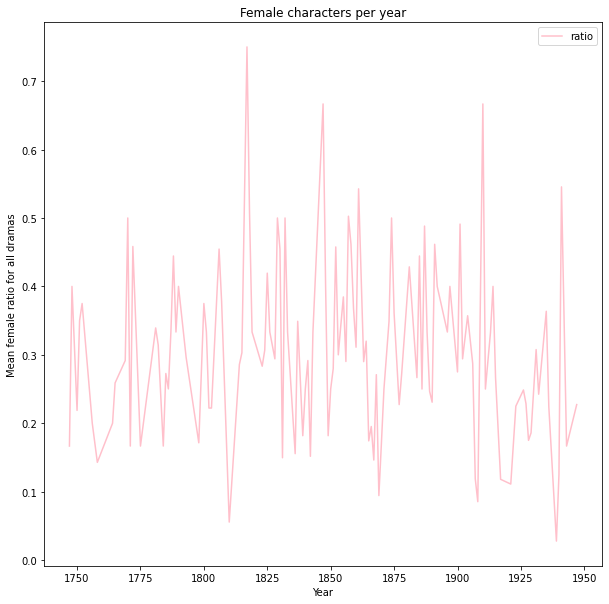

In [278]:

df.groupby('year').agg({"ratio": "mean"}).sort_values(by="year").plot(color='pink', figsize=(10, 10))
plt.title('Female characters per year')
plt.xlabel('Year')
plt.ylabel('Mean female ratio for all dramas')


По годам как будто очевидной зависимости нет. Гипотеза не подтвердилась.

Text(0, 0.5, 'Mean female ratio for all dramas')

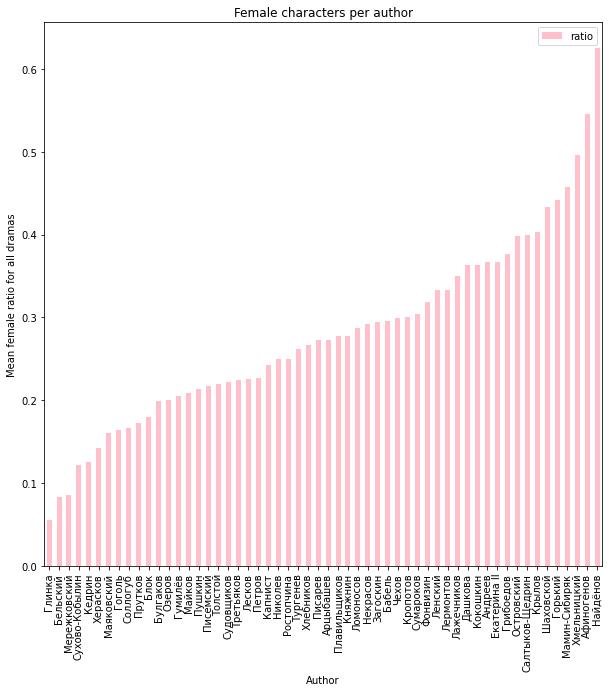

In [276]:
df.groupby('author_name').agg({"ratio": "mean"}).sort_values(by="ratio").plot.bar(color='pink', figsize=(10, 10))
plt.title('Female characters per author')
plt.xlabel('Author')
plt.ylabel('Mean female ratio for all dramas')


У большинства авторов (кроме Найденова, Афиногенова) меньше половины женских персонажей.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55]), <a list of 56 Text major ticklabel objects>)

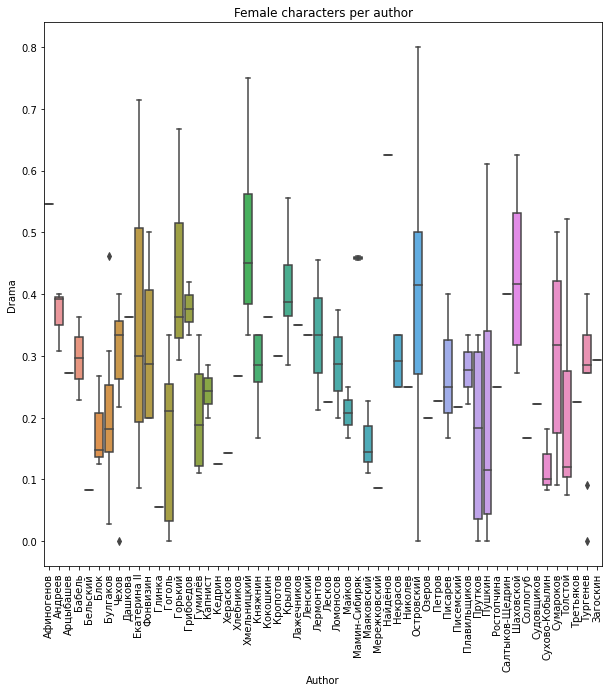

In [277]:
plt.figure(figsize=(10, 10))
sns.boxplot(x="author_name", y="ratio", data=df)

plt.title('Female characters per author')
plt.ylabel('Drama')
plt.xlabel('Author')
plt.xticks(rotation='vertical')

То же самое, только с разбросом. 

Хотя есть разовые выбросы, когда женских персонажей больше мужских (Хмельницкий, Островский), в большинстве пьес преобладают мужские персонажи.

Text(0.5, 1.0, 'Number of the noun head in the title (all data)')

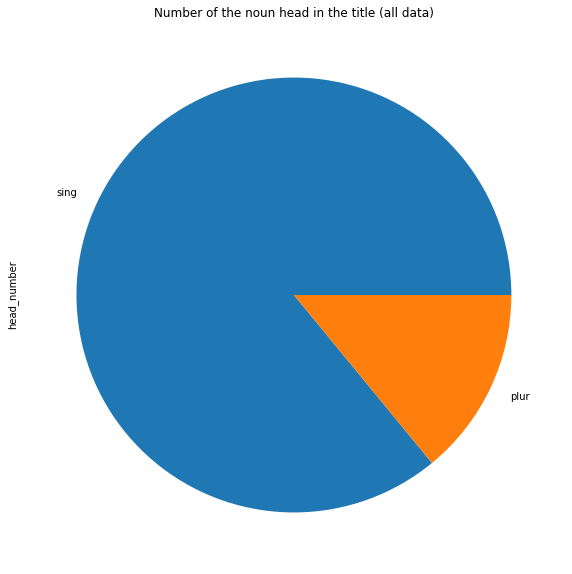

In [279]:
plt.figure(figsize=(10, 10))
df['head_number'].value_counts().plot(kind='pie')
plt.title('Number of the noun head in the title (all data)')

Очевидно чаще в названии (если ИГ) используется единственное число.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]), <a list of 53 Text major ticklabel objects>)

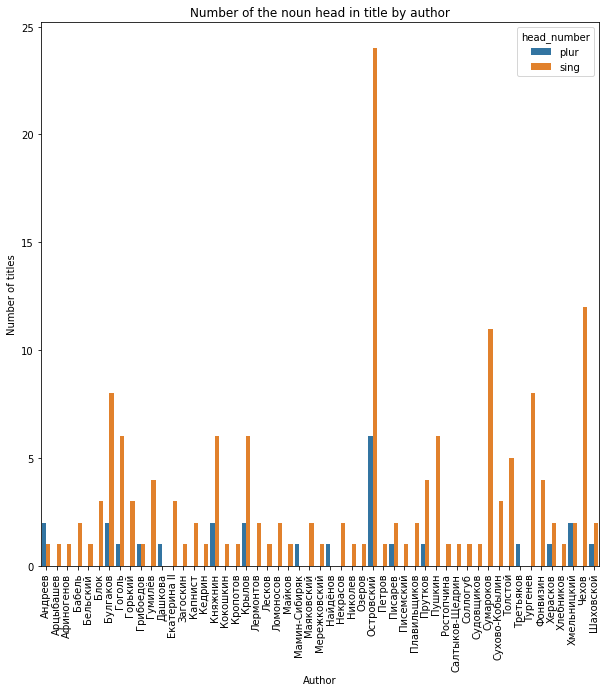

In [280]:
df2 = df.groupby(['author_name', 'head_number'], as_index=False).count()

plt.figure(figsize=(10, 10))
sns.barplot(x="author_name", y="N", hue='head_number', data=df2)
plt.title('Number of the noun head in title by author')
plt.xlabel('Author')
plt.ylabel('Number of titles')
plt.xticks(rotation='vertical')

По авторам тоже гораздо чаще преобладает названия с  вершиной в единственном числе (нагляднее было бы тоже представить доли). 